### Importar bibliotecas

In [1]:
import warnings
warnings.filterwarnings('ignore')
import os

import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import pyplot as plt
from statsmodels.tools.eval_measures import mse
from statsmodels.tsa.arima_model import ARIMAResults

### Carregar dados

In [2]:
# Carregar dados do CPU
workload = pd.read_csv('m_3330.csv', 
             names = ['machine_id', 'time_stamp', 'cpu', 'mem', 'mem_gps', 
                      'mkpi', 'net_in', 'net_out', 'disk_io_percent'])
workload.time_stamp = pd.to_datetime(workload.time_stamp, unit='s')
workload.set_index('time_stamp', inplace=True)
workload = workload.resample('1min').interpolate()
workload

,machine_id,cpu,mem,mem_gps,mkpi,net_in,net_out,disk_io_percent
time_stamp,,,,,,,,
1970-01-01 00:00:00,m_3330,17.0,92.0,NaN,NaN,45.21,38.10,3.0
1970-01-01 00:01:00,m_3330,24.0,92.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:02:00,m_3330,16.0,91.0,NaN,NaN,45.21,38.10,4.0
1970-01-01 00:03:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
1970-01-01 00:04:00,m_3330,16.0,92.0,NaN,NaN,45.22,38.10,4.0
...,...,...,...,...,...,...,...,...
1970-01-08 23:55:00,m_3330,25.0,92.0,5.17,0.0,62.64,55.28,4.0
1970-01-08 23:56:00,m_3330,21.0,90.0,7.04,1.0,62.64,55.28,4.0
1970-01-08 23:57:00,m_3330,26.0,90.0,4.41,0.0,62.65,55.28,4.0


###  Separar treino e teste

In [3]:
# Separar conjunto de treino e de teste dos dadas de CPU
test_len = len(workload)//3
train_set = workload.cpu[:-test_len]
test_set = workload.cpu[-test_len:]

### Modelo ARIMA

In [4]:
# modelo ARIMA
order=(1,0,0)
model_train = ARIMA(train_set, order=order).fit()
model_test = ARIMA(test_set, order=order).fit(model_train.params)
model_test.params

const     42.694827
ar.L1      0.832763
sigma2    39.843238
dtype: float64

### Validação do modelo
Na validação do modelo foi utilizada a técnica do erro quadrático médio, com o método 'mse' da biblioteca statsmodels.
Este método recebe como parâmetro o conjunto de teste e a previsão gerada pelo modelo. O resultado apresentado significa a taxa de erro, quanto menor melhor.

In [5]:
mse(test_set, model_test.predict())

39.84162459430432

### Seleção dos melhores parâmetros
O método ARIMA(p,d,q) recebe 3 parâmetros que representam:
- p: componente autoregressivo
- d: diferença (usado quando a série não é estacionária)
- q: componente de média móvel

O script abaixo cria diversos modelos, com parâmetors distintos e apresenta ao final a melhor ordem (conjunto de parâmetros) do modelo que obteve o menor erro

In [6]:
# define alguns valores limites a serem testados 
# neste caso a diferença (d) será zero, pois a série é estacionária
max_p, max_d, max_q = 12, 0, 5

# cria uma lista com todas as combinações possíveis destes parâmetros, observando os limites definidos acima
orders = []
for p in range(max_p+1):
    for d in range(max_d+1):
        for q in range(max_q+1):
            orders.append((p,d,q))

# valida cada modelo
errors = []
for order in orders:
    saved_model = f'saved_models/arima{"".join(map(str, order))}.pkl'
    if not os.path.isfile(saved_model):
        # cria e salva um modelo caso não exista
        model_train = ARIMA(train_set, order=order).fit()
        model_test = ARIMA(test_set, order=order).fit(model_train.params)
        model_test.save(saved_model)
    else:
        # carrega um modelo salvo
        model_test = ARIMAResults.load(saved_model)
        
    # guarda os erros de cada modelo em uma lista
    error = mse(test_set, model_test.predict())
    errors.append(error)
    print(order, error, end = ' | ')

# identifica a melhor ordem (p,d,q) que apresentou o menor erro
best_order = None
for order, error in zip(orders, errors):
    best_error = min(errors)
    best_order = order if error == best_error else best_order
print(f'\n\nMelhor resultado:\n\tordem: {best_order}\n\terro: {best_error}')

(0, 0, 0) 129.84524486455732 | (0, 0, 1) 72.25104007428565 | (0, 0, 2) 55.7937419123866 | (0, 0, 3) 48.445133218674634 | (0, 0, 4) 45.2405435041367 | (0, 0, 5) 43.535304246812 | (1, 0, 0) 39.84162459430432 | (1, 0, 1) 36.4645720677644 | (1, 0, 2) 35.74750210094735 | (1, 0, 3) 35.06660239809883 | (1, 0, 4) 34.73698442093359 | (1, 0, 5) 34.72463740564743 | (2, 0, 0) 37.32344445899683 | (2, 0, 1) 34.99273311187604 | (2, 0, 2) 34.75202648916373 | (2, 0, 3) 34.72382723883093 | (2, 0, 4) 34.71212709173613 | (2, 0, 5) 34.58812060005872 | (3, 0, 0) 36.87218643340865 | (3, 0, 1) 34.729865022006386 | (3, 0, 2) 34.73339285897584 | (3, 0, 3) 34.72163210769149 | (3, 0, 4) 34.706037167236786 | (3, 0, 5) 34.69760212148971 | (4, 0, 0) 36.527411581154986 | (4, 0, 1) 34.72856471807566 | (4, 0, 2) 34.70892931453725 | (4, 0, 3) 34.713421768587686 | (4, 0, 4) 34.74517139140235 | (4, 0, 5) 34.6462577917944 | (5, 0, 0) 35.83358560086394 | (5, 0, 1) 34.723357014475674 | (5, 0, 2) 34.70855004156479 | (5, 0, 3)

### Comparar previsão x teste

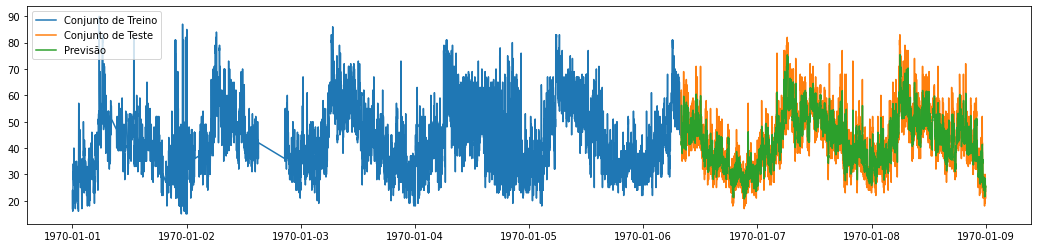

In [7]:
# compara a previsão com o conjunto de teste
plt.figure(figsize=(18,4))
plt.plot(train_set)
plt.plot(test_set)
plt.plot(model_test.predict())
plt.legend(['Conjunto de Treino', 'Conjunto de Teste', 'Previsão'])

### Previsão de valores futuros

1970-01-09    23.444343
Freq: T, dtype: float64

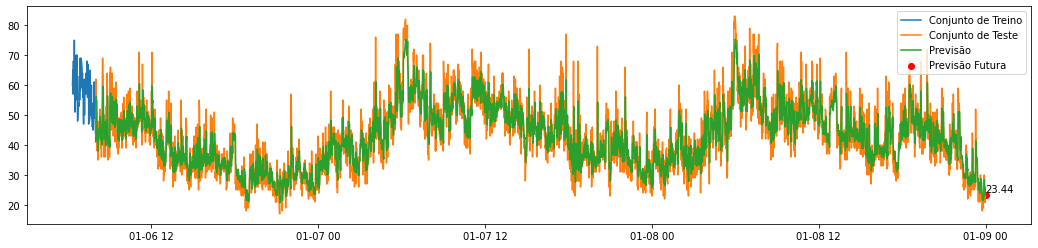

In [8]:
# Próximo passo
predict = model_test.forecast()
plt.figure(figsize=(18,4))
plt.plot(train_set[-100:])
plt.plot(test_set)
plt.plot(model_test.predict())
plt.scatter(predict.index, predict, color='red')
plt.text(predict.index, predict*1.035, f'{predict[0]:.2f}')
plt.legend(['Conjunto de Treino', 'Conjunto de Teste', 'Previsão', 'Previsão Futura'])
predict

1970-01-09 00:00:00    23.444343
1970-01-09 00:01:00    24.204503
1970-01-09 00:02:00    24.829848
1970-01-09 00:03:00    25.173646
1970-01-09 00:04:00    25.349592
                         ...    
1970-01-09 01:35:00    31.809136
1970-01-09 01:36:00    31.827041
1970-01-09 01:37:00    31.892454
1970-01-09 01:38:00    31.954340
1970-01-09 01:39:00    31.986393
Freq: T, Name: predicted_mean, Length: 100, dtype: float64

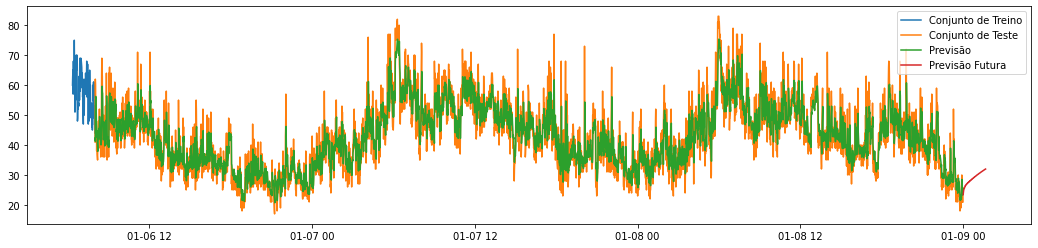

In [9]:
# Conjunto de passos futuros
predict = model_test.forecast(steps=100)
plt.figure(figsize=(18,4))
plt.plot(train_set[-100:])
plt.plot(test_set)
plt.plot(model_test.predict())
plt.plot(predict)
plt.legend(['Conjunto de Treino', 'Conjunto de Teste', 'Previsão', 'Previsão Futura'])
predict